In [1]:
from helper_funcs import *

# Colourblind friendly colours
import tol_colors as tc
cset = tc.tol_cset('bright')
plt.rc('axes', prop_cycle=plt.cycler('color', list(cset)))

blue_tol = [
    '#4477AA',
    '#6d99c5',
    '#9ebbd8',
]

fsize = 24
plt.rcParams.update({'font.size': fsize})


dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

conmap = {
    '000conEC':'EMC (298$\,$K)',
    '033conEC':'EC:EMC (3:7) (298$\,$K)',
    '066conEC':'EC:EMC (7:3) (298$\,$K)',
    '100conEC':'EC (313$\,$K)',
}

tmap = {
    'npt_000conEC_298K':'EMC',
    'npt_033conEC_298K':'EC:EMC',
    'npt_066conEC_298K':'EC:EMC (7:3)',
    'npt_100conEC_313K':'EC',
    'npt_000conEC_300K':'EMC',
    'npt_033conEC_300K':'EC:EMC (3:7)',
    'npt_066conEC_300K':'EC:EMC (7:3)',
    'npt_100conEC_300K':'EC',
}

conmap = {
    '000conEC':'EMC',
    '033conEC':'EC:EMC (3:7)',
    '066conEC':'EC:EMC (7:3)',
    '100conEC':'EC',
}

In [156]:
tags = [
    'SDN22NQQ/wB97X/SEED1/DSET1',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQQ/wB97X/SEED1/DSET3',
    'SDN22NQQ/wB97X/SEED2/DSET1',
    'SDN22NQQ/wB97X/SEED3/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET2',
    'SDN22NQ/wB97X/SEED1/DSET3',
    'SDN22NQ/wB97X/SEED2/DSET1',
    'SDN22NQ/wB97X/SEED3/DSET1',
    'SDN22N/wB97X/SEED1/DSET1',
    'SDN22N/wB97X/SEED2/DSET1',
    'SDN22N/wB97X/SEED3/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

In [3]:
import pickle

def get_mol_positions(atoms):
	positions = []
	mol_set = set(atoms.arrays['molID'])
	for ID in mol_set:
		mol = atoms[atoms.arrays['molID'] == ID]
		com = mol.get_center_of_mass()
		positions.append(com)
	positions = np.array(positions)
	return positions#, len(mol_set)

def mol_rdf(atoms, rmax, nbins, return_num_mols=False):
	positions = get_mol_positions(atoms)
	nmols, dim = positions.shape
	box_length = atoms.get_volume()**(1/3)
	for i, p in enumerate(positions):
		# PBC
		delta = positions[i+1:]-positions[i]
		delta -= box_length*np.round(delta/box_length)
		
		# Get counts
		dists = np.linalg.norm(delta, axis=1)
		s = sorted(dists[dists <= rmax])[1:]
		if i == 0:
			counts, bins = np.histogram(s, nbins, (0,rmax))
		else:
			counts += np.histogram(s, nbins, (0,rmax))[0]

	if return_num_mols:
		return counts, bins, nmols
	else:
		return counts, bins

def compute_rdf(traj, rmax=None, nbins=100, return_rho=False):
	for i, atoms in enumerate(traj):
		if i == 0:
			counts, bins, nmols = mol_rdf(atoms, rmax=rmax, nbins=nbins, return_num_mols=True)
			volume = atoms.get_volume()
			box_length = volume**(1/3)
			r = 0.5*(bins[1:]+bins[:-1])
		else:
			counts += mol_rdf(atoms, rmax=rmax, nbins=nbins)[0]
	
	num_snapshots = i+1
	nvalid = nmols/2
	n_k = counts/(nvalid*num_snapshots)	
	dr = rmax/nbins
	shell_volumes = 4/3*np.pi*((r+dr)**3-r**3)
	rho = nmols/volume
	
	g = n_k/(rho*shell_volumes)
	if return_rho:
		return g, r, rho
	else:
		return g, r

def get_indices_of_sign_change(lst):
    arr = np.array(lst)
    sign_changes = np.where(np.diff(np.sign(arr)) != 0)[0]
    #sign_changes = sign_changes[sign_changes>55] # The limit was taken from observation
    return sign_changes



def eval_rdfs(tags, traj_path, slice=':'):
    rdfs = {}
    number_densities = {}
    for tag in tags:
        data_set, functional, seed, dset_sample = tag.split('/')
        flist = [name for name in glob.glob(f'{traj_path}{tag}/*') if '.xyz' in name]
        name = f'{data_set}_{functional}'
        print(name, dset_sample, seed)

        for file in flist:
            print(file)
            comp = file.split('/')[-1].split('.')[0][4:-5]
            comp = conmap[comp]
            traj = read(file, slice)
            aa.find_molecs(traj, fct=1.0)
            g, r, rho = compute_rdf(traj, rmax=11, return_rho=True)

            if name not in rdfs:
                rdfs[name] = {}
            if dset_sample not in rdfs[name]:
                rdfs[name][dset_sample] = {}
            if seed not in rdfs[name][dset_sample]:
                rdfs[name][dset_sample][seed] = {}
            
            if name not in number_densities:
                number_densities[name] = {}
            if dset_sample not in number_densities[name]:
                number_densities[name][dset_sample] = {}
            if seed not in number_densities[name][dset_sample]:
                number_densities[name][dset_sample][seed] = {}

            rdfs[name][dset_sample][seed][comp] = [g, r]
            number_densities[name][dset_sample][seed][comp] = rho
            del traj
    
    return rdfs, number_densities



In [4]:
import pickle

def get_mol_positions(atoms):
	positions = []
	mol_set = set(atoms.arrays['molID'])
	for ID in mol_set:
		mol = atoms[atoms.arrays['molID'] == ID]
		com = mol.get_center_of_mass()
		positions.append(com)
	positions = np.array(positions)
	return positions#, len(mol_set)

def mol_rdf(atoms, rmax, nbins, return_num_mols=False):
	positions = get_mol_positions(atoms)
	nmols, dim = positions.shape
	box_length = atoms.get_volume()**(1/3)
	for i, p in enumerate(positions):
		# PBC
		delta = positions[i+1:]-positions[i]
		delta -= box_length*np.round(delta/box_length)
		
		# Get counts
		dists = np.linalg.norm(delta, axis=1)
		s = sorted(dists[dists <= rmax])[1:]
		if i == 0:
			counts, bins = np.histogram(s, nbins, (0,rmax))
		else:
			counts += np.histogram(s, nbins, (0,rmax))[0]

	if return_num_mols:
		return counts, bins, nmols
	else:
		return counts, bins

def compute_rdf(traj, rmax=None, nbins=100, return_rho=False):
	for i, atoms in enumerate(traj):
		if i == 0:
			counts, bins, nmols = mol_rdf(atoms, rmax=rmax, nbins=nbins, return_num_mols=True)
			volume = atoms.get_volume()
			box_length = volume**(1/3)
			r = 0.5*(bins[1:]+bins[:-1])
		else:
			counts += mol_rdf(atoms, rmax=rmax, nbins=nbins)[0]
	
	num_snapshots = i+1
	nvalid = nmols/2
	n_k = counts/(nvalid*num_snapshots)	
	dr = rmax/nbins
	shell_volumes = 4/3*np.pi*((r+dr)**3-r**3)
	rho = nmols/volume
	
	g = n_k/(rho*shell_volumes)
	if return_rho:
		return g, r, rho
	else:
		return g, r

def get_indices_of_sign_change(lst):
    arr = np.array(lst)
    sign_changes = np.where(np.diff(np.sign(arr)) != 0)[0]
    #sign_changes = sign_changes[sign_changes>55] # The limit was taken from observation
    return sign_changes



def eval_rdfs(tags, traj_path, slice=':'):
    rdfs = {}
    number_densities = {}
    for tag in tags:
        data_set, functional, seed, dset_sample = tag.split('/')
        flist = [name for name in glob.glob(f'{traj_path}{tag}/*') if '.xyz' in name]
        name = f'{data_set}_{functional}'
        print(name, dset_sample, seed)

        for file in flist:
            print(file)
            comp = file.split('/')[-1].split('.')[0][4:-5]
            comp = conmap[comp]
            traj = read(file, slice)
            aa.find_molecs(traj, fct=1.0)
            g, r, rho = compute_rdf(traj, rmax=11, return_rho=True)

            if name not in rdfs:
                rdfs[name] = {}
            if dset_sample not in rdfs[name]:
                rdfs[name][dset_sample] = {}
            if seed not in rdfs[name][dset_sample]:
                rdfs[name][dset_sample][seed] = {}
            
            if name not in number_densities:
                number_densities[name] = {}
            if dset_sample not in number_densities[name]:
                number_densities[name][dset_sample] = {}
            if seed not in number_densities[name][dset_sample]:
                number_densities[name][dset_sample][seed] = {}

            rdfs[name][dset_sample][seed][comp] = [g, r]
            number_densities[name][dset_sample][seed][comp] = rho
            del traj
    
    return rdfs, number_densities

def get_start_index(time, msd, threshold, window, start_id=0):
    window = int(window)
    start_id = int(start_id)
    print(f'Using slope error thresold of: {threshold}')
    #time = time
    ids = {}
    for i, t in enumerate(time[start_id:]):
        if i > window:
            
            slope, intercept, err, r2 = get_slope(np.log(time[i:i+window]),np.log(msd[i:i+window]))
            if abs(slope-1) < threshold:
                #idx = start_id+i
                ids[start_id+i] = r2
            #else:
            #    idx = None
    idx, r2 = max(ids.items(), key=lambda x: x[1])
    return idx, r2

def get_colour(name):
    import tol_colors as tc
    cset = tc.tol_cset('bright')

    colmap = {
        'EMC (298$\,$K)':'blue',
        'EMC (300$\,$K)':'blue',
        'EC:EMC (3:7) (298$\,$K)':'green',
        'EC:EMC (3:7) (300$\,$K)':'green',
        'EC:EMC (7:3) (298$\,$K)':'yellow',
        'EC:EMC (7:3) (300$\,$K)':'yellow',
        'EC (313$\,$K)':'red',
        'EC (300$\,$K)':'red',
    }

    tmap = {
        'npt_000conEC_298K':'EMC (298$\,$K)',
        'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
        'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
        'npt_100conEC_313K':'EC (313$\,$K)',
        'npt_000conEC_300K':'EMC (300$\,$K)',
        'npt_033conEC_300K':'EC:EMC (3:7) (300$\,$K)',
        'npt_066conEC_300K':'EC:EMC (7:3) (300$\,$K)',
        'npt_100conEC_300K':'EC (300$\,$K)',
    }
    try:
        return getattr(cset, colmap[name])
    except:
        return getattr(cset, colmap[tmap[name]])




In [5]:
def get_dens(tags, root_path, std=False):
    thermo = dict()
    for tag in tags:
        thermo[tag] = get_all_thermo(f'{root_path}{tag}/*.thermo')
    
    densities = dict()
    densities_std = dict()
    for i, k in enumerate(thermo):
        tag = tags[i]
        densities[tag] = {}
        densities_std[tag] = {}
        for traj_name, traj_data in thermo[k].items():
            # Collect data
            if 'GAP' in tag:
                dens, dunit = traj_data['v_mdensity']['data'], '?'
            else:
                dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            #densities[tag]['units'] = dunit
            densities[tag][traj_name] = np.mean(dens)
            densities_std[tag][traj_name] = np.std(dens)
    if std:
        return densities, densities_std, dunit
    else:
        return densities, dunit


def get_density(tags, dynamics_path, std=False):
    conmap = {
        '000conEC':'EMC (298$\,$K)',
        '033conEC':'EC:EMC (3:7) (298$\,$K)',
        '066conEC':'EC:EMC (7:3) (298$\,$K)',
        '100conEC':'EC (313$\,$K)',
    }
    conmap = {
        '000conEC':'EMC',
        '033conEC':'EC:EMC (3:7)',
        '066conEC':'EC:EMC (7:3)',
        '100conEC':'EC',
    }
    
    
    # Compute average densities
    dens = dict()
    if std:
        dens, denstd, dunit = get_dens(tags, dynamics_path, std=True)
    else:
        dens, dunit = get_dens(tags, dynamics_path)
    print(dens)

    # Collect average densities for all tags
    data = {
        'Train data':[],
        'Functional':[],
        'Seed':[],
        'Sample':[],
        'Composition':[],
        'Temperature':[],
        'Avg. density':[],
    }
    if std:
        data |= {'Std. density':[]}

    for tag, d in dens.items():
        data_set, functional, seed, dset_sample = tag.split('/')
        seed = int(seed[-1]); dset_sample = int(dset_sample[-1])

        # Add one instance per composition
        for i in range(4):
            data['Train data'].append(data_set)
            data['Functional'].append(functional)
            data['Seed'].append(seed)
            data['Sample'].append(dset_sample)
        
        # Add average densities for each composition
        for traj_name, avg_dens in d.items():
            
            #print(comp)
            _, comp, temp = traj_name.split('_')
            temp = temp[:-1]
            data['Composition'].append(conmap[comp])
            data['Temperature'].append(temp)
            #data['Composition'].append(tmap[traj_name])
            
            data['Avg. density'].append(avg_dens)
            if std:
                data['Std. density'].append(denstd[tag][traj_name])
    #for key,val in data.items():
    #    print(key, len(val))
    return pd.DataFrame(data), dunit



def get_colour(name):
    import tol_colors as tc
    cset = tc.tol_cset('bright')

    colmap = {
        'EMC':'blue',
        'EC:EMC (3:7)':'green',
        'EC:EMC (7:3)':'yellow',
        'EC':'red',
    }

    tmap = {
        'npt_000conEC_298K':'EMC',
        'npt_033conEC_298K':'EC:EMC (3:7)',
        'npt_066conEC_298K':'EC:EMC (7:3)',
        'npt_100conEC_313K':'EC',
        'npt_000conEC_300K':'EMC',
        'npt_033conEC_300K':'EC:EMC (3:7)',
        'npt_066conEC_300K':'EC:EMC (7:3)',
        'npt_100conEC_300K':'EC',
    }
    try:
        return getattr(cset, colmap[name])
    except:
        return getattr(cset, colmap[tmap[name]])
    


# Data set statistics

In [ ]:
# REMOVE?

def cache_stats(stats_dict, name, from_dict=False):
    try:
        stats_df = pd.read_pickle(name)
    except:
        if from_dict:
            stats_df = pd.DataFrame.from_dict(stats_dict)
        else:
            stats_df = pd.DataFrame(stats_dict)
        stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
        stats_df.index += 1
        pd.to_pickle(stats_df, name)
    return stats_df

def cache_dict(stats_dict, name):
    try:
        stats_dict = pd.read_pickle(name)
    except:
        pd.to_pickle(stats_df, name)
    return stats_df

## Small data set (SD22NQQ)

In [277]:
import pickle
from ase.io import read

pkl_name = './SD22NQQ_xyz.pkl'

SD22NQQ1 = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET1/train_data/SD22NQQ1_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms
SD22NQQ2 = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET2/train_data/SD22NQQ2_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms
SD22NQQ3 = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET3/train_data/SD22NQQ3_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms

xyz_dict = {'SD22NQQ1':SD22NQQ1, 'SD22NQQ2':SD22NQQ2, 'SD22NQQ3':SD22NQQ3}
with open(pkl_name, 'wb') as f:
    pickle.dump(xyz_dict, f)

### Cluster composition

In [11]:
import pickle

pkl_name = './SD22NQQ_xyz.pkl'

with open(pkl_name, 'rb') as f:
    SD22NQQ_dict = pickle.load(f)

SD22NQQ1_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ_dict['SD22NQQ1']]), [1,2,3,4,5,6,7])[0]
SD22NQQ2_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ_dict['SD22NQQ2']]), [1,2,3,4,5,6,7])[0]
SD22NQQ3_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ_dict['SD22NQQ3']]), [1,2,3,4,5,6,7])[0]
SD22NQQ_stats_dict = {'SD22NQQ1':SD22NQQ1_stats, 'SD22NQQ2':SD22NQQ2_stats, 'SD22NQQ3':SD22NQQ3_stats}

SD22NQQ_stats_df = pd.DataFrame(SD22NQQ_stats_dict)
SD22NQQ_stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
SD22NQQ_stats_df.index += 1
SD22NQQ_stats_df

,SD22NQQ1,SD22NQQ2,SD22NQQ3
"Cluster size, $N_\text{mols}$",,,
1,900,900,900
2,1470,1470,1470
3,2001,2001,2001
4,1917,1917,1917
5,1464,1464,1464
6,264,264,264


### Molecular composition

In [284]:
data = 'SD22NQQ1'
print(f'{data}:')
comp = collect_comp(SD22NQQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQQ1:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


In [285]:
data = 'SD22NQQ2'
print(f'{data}:')
comp = collect_comp(SD22NQQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQQ2:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


In [286]:
data = 'SD22NQQ3'
print(f'{data}:')
comp = collect_comp(SD22NQQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQQ3:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


## Medium data set (SD22NQ)

In [21]:
import pickle
from ase.io import read

pkl_name = './SD22NQ_xyz.pkl'

SD22NQ1 = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET1/train_data/SD22NQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22NQ2 = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET2/train_data/SD22NQ2_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms
SD22NQ3 = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET3/train_data/SD22NQ3_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms

xyz_dict = {'SD22NQ1':SD22NQ1, 'SD22NQ2':SD22NQ2, 'SD22NQ3':SD22NQ3}
with open(pkl_name, 'wb') as f:
    pickle.dump(xyz_dict, f)

### Cluster composition

In [23]:
import pickle

pkl_name = './SD22NQ_xyz.pkl'

with open(pkl_name, 'rb') as f:
    SD22NQ_dict = pickle.load(f)

SD22NQ1_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ_dict['SD22NQ1']]), [1,2,3,4,5,6,7])[0]
SD22NQ2_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ_dict['SD22NQ2']]), [1,2,3,4,5,6,7])[0]
SD22NQ3_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ_dict['SD22NQ3']]), [1,2,3,4,5,6,7])[0]
SD22NQ_stats_dict = {'SD22NQ1':SD22NQ1_stats, 'SD22NQ2':SD22NQ2_stats, 'SD22NQ3':SD22NQ3_stats}

SD22NQ_stats_df = pd.DataFrame(SD22NQ_stats_dict)
SD22NQ_stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
SD22NQ_stats_df.index += 1
SD22NQ_stats_df

,SD22NQ1,SD22NQ2,SD22NQ3
"Cluster size, $N_\text{mols}$",,,
1,7880,7880,7880
2,18253,18253,18253
3,10176,10176,10176
4,4787,4787,4787
5,1464,1464,1464
6,264,264,264


### Molecular composition

In [290]:
data = 'SD22NQ1'
print(f'{data}:')
comp = collect_comp(SD22NQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQ1:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


In [291]:
data = 'SD22NQ2'
print(f'{data}:')
comp = collect_comp(SD22NQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQ2:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,887,2354,0,0,4639
2,1069,190,1092,9088,6814
3,178,1091,516,2433,5958
4,41,1528,189,706,2323
5,25,322,139,344,634
6,0,0,144,110,10


In [292]:
data = 'SD22NQ3'
print(f'{data}:')
comp = collect_comp(SD22NQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQ3:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,887,2354,0,0,4639
2,1069,190,1092,9088,6814
3,178,1091,516,2433,5958
4,41,1528,189,706,2323
5,25,322,139,344,634
6,0,0,144,110,10


## Large data set (SD22N)

In [293]:
import pickle
from ase.io import read

pkl_name = './SD22N_xyz.pkl'

SD22N = read(f'{static_path}/SDN22N/wB97X/SEED1/DSET1/train_data/SD22N_wB97XD3BJ_Psi4.xyz', ':')

xyz_dict = {'SD22N':SD22N}
with open(pkl_name, 'wb') as f:
    pickle.dump(xyz_dict, f)

### Cluster composition

In [7]:
import pickle

pkl_name = './SD22N_xyz.pkl'

with open(pkl_name, 'rb') as f:
    SD22N_dict = pickle.load(f)

SD22N_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22N_dict['SD22N']]), [1,2,3,4,5,6,7])[0]
SD22N_stats_dict = {'SD22N':SD22N_stats}

SD22N_stats_df = pd.DataFrame(SD22N_stats_dict)
SD22N_stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
SD22N_stats_df.index += 1
SD22N_stats_df

,SD22N
"Cluster size, $N_\text{mols}$",
1,77880
2,82253
3,37176
4,17787
5,6464
6,264


### Molecular composition

In [8]:
data = 'SD22N'
print(f'{data}:')
comp = collect_comp(SD22N_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22N:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,887,72354,0,0,4639
2,1069,40190,1092,9088,30814
3,178,23091,516,2433,10958
4,41,11528,189,706,5323
5,25,5322,139,344,634
6,0,0,144,110,10


## Overall statistics

### Expected cluster sizes

In [25]:
dfs = {
    'SD22NQQ':SD22NQQ_stats_df['SD22NQQ1'],
    'SD22NQ':SD22NQ_stats_df['SD22NQ1'],
    'SD22N':SD22N_stats_df['SD22N'],
}
stats_df = pd.concat(dfs.values(), axis=1, keys=dfs.keys())

In [26]:
tot = stats_df.aggregate('sum', axis=0)
stats_dist_df = stats_df/tot
clusters = np.arange(1, len(stats_dist_df)+1)
print(clusters)
expectation = (stats_dist_df*clusters[:,None]).aggregate('sum', axis=0).round(decimals=2)
second_moment = (stats_dist_df*clusters[:,None]**2).aggregate('sum', axis=0).round(decimals=2)
variance = second_moment-expectation**2
print(expectation)
print(variance**0.5)
SD22N_cluster_size, SD22NQ_cluster_size, SD22NQQ_cluster_size = expectation

[1 2 3 4 5 6]
SD22NQQ    3.30
SD22NQ     2.40
SD22N      2.07
dtype: float64
SD22NQQ    1.334166
SD22NQ     1.063015
SD22N      1.055983
dtype: float64


In [18]:
a = expectation**2/variance**0.5
a

SD22NQQ    8.094473
SD22NQ     8.094473
SD22N      4.432217
dtype: float64

In [17]:
l = expectation/variance**0.5
l

SD22NQQ    2.452871
SD22NQ     2.452871
SD22N      2.110579
dtype: float64

### Visual distributions

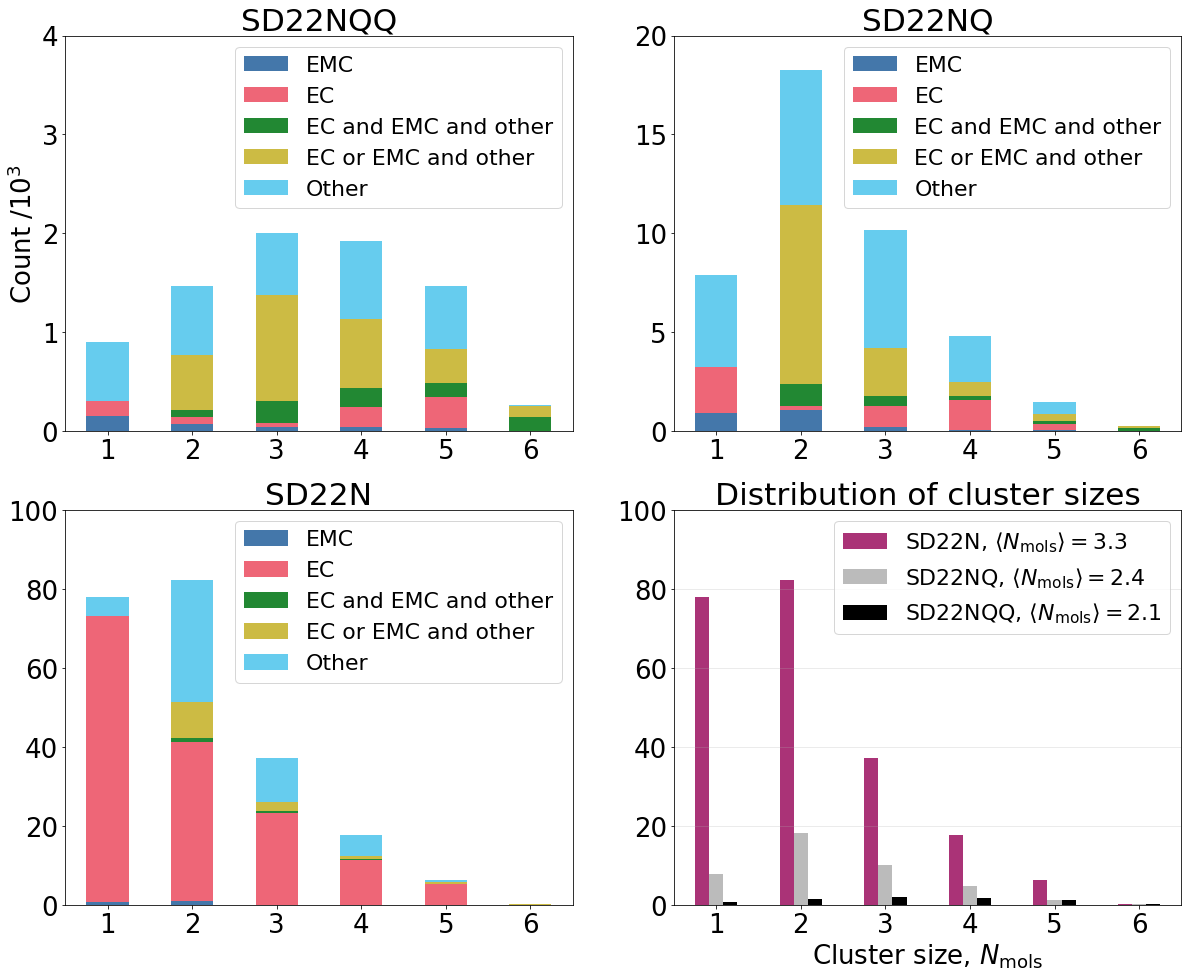

In [34]:
fsize = 26
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(2,2, figsize=(10*2, 8*2), sharey=False)
comps = {
    'SD22NQQ':SD22NQQ1_comp_flat,
    'SD22NQ':SD22NQ1_comp_flat,
    'SD22N':SD22N_comp_flat,
}
axs = axs.ravel()
for i, (ax, (name, data)) in enumerate(zip(axs, comps.items())):
    d = data/1e3
    if i == 0:
        ax.set_ylim([0,4])
    elif i == 1:
        ax.set_ylim([0,20])
    else:
        ax.set_ylim([0,100])

    d.plot.bar(ax=ax, legend=False, stacked=True, rot=0)
    #ax.set_yscale('log')
    ax.legend(fontsize=fsize-4, ncols=1)
    ax.set_title(name)

axs[0].set_ylabel('Count /$10^3$')

axs[-1].set_title('Distribution of cluster sizes')
scaled_stats_df = stats_df/1e3
scaled_stats_df[['SD22N', 'SD22NQ', 'SD22NQQ']].plot.bar(
#stats_df.plot.bar(
    #ylabel='Count /$10^4$',
	rot=0,
	ax=axs[-1],
    color=cset[5:],
)
axs[-1].set_ylim([0,100])

axs[-1].grid(axis='y', alpha=0.3)
axs[-1].legend(
    [
        f'SD22N, $\\langle N_\\text{{mols}} \\rangle = {SD22N_cluster_size}$',
        f'SD22NQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQ_cluster_size}$',
        f'SD22NQQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQQ_cluster_size}$',
    ],
    fontsize=fsize-4,
)